In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood
from sklearn.model_selection import train_test_split

In [28]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset

In [12]:
batch_size = 64
aug = 10
data_path = '../data/'
device = 'cuda'

In [13]:
lrg_data_set   = LRG(112, rd_sz=128, use_kittler=True, n_aug=aug, blur=False, 
                     catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                     file_dir=data_path + 'lrg')

../data/lrg:	1442/1442


In [14]:
data_path = '../data/'

x = np.load(data_path+'proc_aligned2/lrg_norm_proc.npy', allow_pickle=True)

In [15]:
_, y = lrg_data_set.get_data()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [19]:
train_dataset = BasicDataset(X_train, y_train, n_aug=5, sz=112, rotation=18) #
test_dataset  = BasicDataset(X_test,  y_test,  n_aug=5, sz=112, rotation=18)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [21]:
x.shape

(1429, 64, 64)

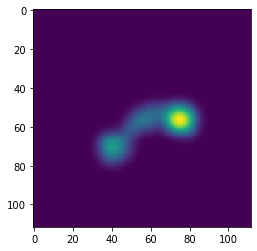

In [33]:
sample = iter(test_dataloader).next()
plt.imshow(sample[0].numpy()[10][0])
plt.show()

In [34]:
class DeepClassifier(nn.Module):
    ''' Somewhat inspired in VGG'''
    def __init__(self, k=None, num_classes=6, lt_dim=8, batchnorm=True, in_channels=1, non_linearity=nn.ReLU,
                 Conv2d=nn.Conv2d, MaxPool2d=nn.MaxPool2d, BatchNorm2d=nn.BatchNorm2d):
        super(DeepClassifier, self).__init__()
        
        self.non_linearity = non_linearity
        self.Conv2d = Conv2d
        self.MaxPool2d = MaxPool2d
        self.BatchNorm2d = BatchNorm2d
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(k[-2] * 7 * 7, lt_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(lt_dim, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
        if k == None:
            k = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

        layers = self.__make_layers(k, batchnorm)
        self.features = nn.Sequential(*layers)
        self._initialize_weights()

    def __make_layers(self, k, batch_norm, in_channels=1):
        layers = []
        for v in k:
            if v == 'M' :
                layers += [self.MaxPool2d(kernel_size=2, stride=2)]
            else :
                conv2d = self.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, self.BatchNorm2d(v), self.non_linearity(inplace=True)]
                else:
                    layers += [conv2d, self.non_linearity(inplace=True)]
                in_channels = v
#         for l in layers: print(l)
        return layers

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.features(x)
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        return y

'''Common configs for VGG like networks'''
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M'],
}

In [35]:
def train(model, dataloader, optimizer, epoch, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # backward + optimize
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs
        
        s = 'Train Epoch: {:3d} ({:3.0f}%)\tLoss:\t{:4.4f}\trLoss: {:4.2f}\tTrain Acc: {:.4f}'
        s = s.format(epoch,
                100. * batch_idx / len(dataloader), loss.item(), running_loss, running_acc)
        sys.stdout.write('{}\r'.format(s))
        sys.stdout.flush()
    return running_loss, running_corrects, s

In [36]:
def test(model, dataloader, optimizer, epoch, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs
        
#         s = 'Test Epoch: {:3d} ({:3.0f}%)\tLoss:\t{:4.4f}\trLoss: {:4.2f}\trPreds: {:.4f}'
#         s = s.format(epoch,
#                 100. * batch_idx / len(dataloader), loss.item(), running_loss, running_acc)
#         sys.stdout.write('{}\r'.format(s))
#         sys.stdout.flush()

    return running_loss, running_acc#, s

In [39]:
epochs = 100
lr = 0.0005

In [40]:
k = [16, 'M', 32, 'M', 64, 64, 'M', 128, 128, 'M']
model = DeepClassifier(k=k, batchnorm=False).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

for epoch in range(1, epochs+1):
    start = time.time()
    train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
    test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
    t = time.time() - start
    print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))
#     scheduler.step()

Train Epoch:   1 ( 99%)	Loss:	1.4531	rLoss: 7712.17	Train Acc: 0.2780 Test Acc: 0.2669	Time: 2.7911
Train Epoch:   2 ( 99%)	Loss:	1.1340	rLoss: 6642.32	Train Acc: 0.3931 Test Acc: 0.5648	Time: 2.7680
Train Epoch:   3 ( 99%)	Loss:	1.1031	rLoss: 5608.32	Train Acc: 0.5534 Test Acc: 0.5953	Time: 2.7717
Train Epoch:   4 ( 99%)	Loss:	1.0279	rLoss: 5228.32	Train Acc: 0.5760 Test Acc: 0.6318	Time: 2.8136
Train Epoch:   5 ( 99%)	Loss:	1.0604	rLoss: 5103.08	Train Acc: 0.5889 Test Acc: 0.6508	Time: 2.8166
Train Epoch:   6 ( 99%)	Loss:	1.0457	rLoss: 5046.50	Train Acc: 0.5971 Test Acc: 0.6538	Time: 2.8024
Train Epoch:   7 ( 99%)	Loss:	1.3121	rLoss: 5023.44	Train Acc: 0.5927 Test Acc: 0.6492	Time: 2.8264
Train Epoch:   8 ( 99%)	Loss:	0.9636	rLoss: 4992.35	Train Acc: 0.5912 Test Acc: 0.6750	Time: 2.7940
Train Epoch:   9 ( 99%)	Loss:	1.1102	rLoss: 4890.07	Train Acc: 0.6050 Test Acc: 0.6712	Time: 2.7876
Train Epoch:  10 ( 99%)	Loss:	1.0373	rLoss: 4909.93	Train Acc: 0.6042 Test Acc: 0.6555	Time: 2.7937


Train Epoch:  83 ( 99%)	Loss:	0.4542	rLoss: 2640.46	Train Acc: 0.8180 Test Acc: 0.4581	Time: 2.7853
Train Epoch:  84 ( 99%)	Loss:	0.7748	rLoss: 2744.30	Train Acc: 0.8098 Test Acc: 0.4869	Time: 2.7958
Train Epoch:  85 ( 99%)	Loss:	0.6497	rLoss: 2693.84	Train Acc: 0.8199 Test Acc: 0.6614	Time: 2.7869
Train Epoch:  86 ( 99%)	Loss:	0.6035	rLoss: 2551.69	Train Acc: 0.8245 Test Acc: 0.5792	Time: 2.7559
Train Epoch:  87 ( 99%)	Loss:	0.4292	rLoss: 2563.79	Train Acc: 0.8270 Test Acc: 0.5725	Time: 2.8135
Train Epoch:  88 ( 99%)	Loss:	0.5932	rLoss: 2501.33	Train Acc: 0.8328 Test Acc: 0.5106	Time: 2.7974
Train Epoch:  89 ( 99%)	Loss:	0.2369	rLoss: 2539.14	Train Acc: 0.8272 Test Acc: 0.6441	Time: 2.8237
Train Epoch:  90 ( 99%)	Loss:	0.4423	rLoss: 2436.58	Train Acc: 0.8332 Test Acc: 0.6691	Time: 2.8001
Train Epoch:  91 ( 99%)	Loss:	0.4467	rLoss: 2457.30	Train Acc: 0.8382 Test Acc: 0.5093	Time: 2.8080
Train Epoch:  92 ( 99%)	Loss:	0.5966	rLoss: 2424.24	Train Acc: 0.8362 Test Acc: 0.5576	Time: 2.8130


In [ ]:
model = DeepClassifier(k=cfgs['vgg11'], batchnorm=False).to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, epochs+1):
    start = time.time()
    train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
    test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
    t = time.time() - start
    print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))

Train Epoch:   1 (100%)	Loss:	1.0175	rLoss: 18539.22	Train Acc: 0.4754 Test Acc: 0.5508	Time: 19.7872
Train Epoch:   2 (100%)	Loss:	1.1239	rLoss: 16659.75	Train Acc: 0.5259 Test Acc: 0.6280	Time: 19.7435
Train Epoch:   3 (100%)	Loss:	1.5436	rLoss: 15691.66	Train Acc: 0.5445 Test Acc: 0.6716	Time: 19.7382
Train Epoch:   4 (100%)	Loss:	1.3230	rLoss: 14963.62	Train Acc: 0.5739 Test Acc: 0.7008	Time: 19.7127
Train Epoch:   5 (100%)	Loss:	0.7608	rLoss: 14002.21	Train Acc: 0.6114 Test Acc: 0.6581	Time: 19.6995
Train Epoch:   6 (100%)	Loss:	0.8188	rLoss: 13210.84	Train Acc: 0.6374 Test Acc: 0.6309	Time: 19.6886
Train Epoch:   7 (100%)	Loss:	0.8563	rLoss: 13041.09	Train Acc: 0.6421 Test Acc: 0.7178	Time: 19.8489
Train Epoch:   8 (100%)	Loss:	0.5412	rLoss: 12513.54	Train Acc: 0.6596 Test Acc: 0.7424	Time: 20.6705
Train Epoch:   9 (100%)	Loss:	0.5247	rLoss: 11904.67	Train Acc: 0.6869 Test Acc: 0.7449	Time: 20.6111
Train Epoch:  10 (100%)	Loss:	0.7558	rLoss: 11481.35	Train Acc: 0.6931 Test Acc: 0

Train Epoch:  82 (100%)	Loss:	0.3703	rLoss: 3100.65	Train Acc: 0.9256 Test Acc: 0.5742	Time: 19.5800
Train Epoch:  83 (100%)	Loss:	0.2236	rLoss: 3058.07	Train Acc: 0.9234 Test Acc: 0.5500	Time: 19.7094
Train Epoch:  84 (100%)	Loss:	0.1332	rLoss: 2991.91	Train Acc: 0.9280 Test Acc: 0.6250	Time: 19.7085
Train Epoch:  85 (100%)	Loss:	0.0527	rLoss: 2946.16	Train Acc: 0.9299 Test Acc: 0.6225	Time: 19.5057
Train Epoch:  86 (100%)	Loss:	0.3163	rLoss: 2810.35	Train Acc: 0.9305 Test Acc: 0.6619	Time: 19.0402
Train Epoch:  87 (100%)	Loss:	0.0327	rLoss: 2945.06	Train Acc: 0.9289 Test Acc: 0.5458	Time: 19.7019
Train Epoch:  88 (100%)	Loss:	0.2243	rLoss: 2680.63	Train Acc: 0.9353 Test Acc: 0.5364	Time: 19.1392
Train Epoch:  89 (100%)	Loss:	0.4447	rLoss: 2701.02	Train Acc: 0.9339 Test Acc: 0.5377	Time: 19.1494
Train Epoch:  90 (100%)	Loss:	0.1578	rLoss: 3120.55	Train Acc: 0.9259 Test Acc: 0.6915	Time: 19.9723
Train Epoch:  91 (100%)	Loss:	0.0553	rLoss: 2783.22	Train Acc: 0.9334 Test Acc: 0.5059	Time